In [1]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymc as pm
import scipy.stats as stats
import helpsk as hlp

import source.pymc_helpers as ph

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Data

In [2]:
data = pd.read_csv("/code/data/Howell1.csv", sep=";", header=0)
print(len(data))
data.head()

544


height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

In [3]:
hlp.pandas.numeric_summary(data)

---

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, FunctionTransformer

def transform_is_adult(X):
    values = X[['age']].apply(lambda v: 1 if (v >= 18).all() else 0, axis=1).values
    return np.reshape(values, (-1, 1))

pipeline = make_column_transformer(
    (make_pipeline(StandardScaler(), PolynomialFeatures(3, include_bias=False)), ['weight']),
    (FunctionTransformer(func=transform_is_adult), ['age']),
    ('passthrough', ['male']),
)

# pipeline = make_pipeline(
#     StandardScaler(),
#     make_column_transformer((PolynomialFeatures(3, include_bias=False), ['weight']))
# )

X = data.copy().drop(columns='height')
y = data['height']

print(X.head())
X = pipeline.fit_transform(X)
X.shape


      weight   age  male
0  47.825606  63.0     1
1  36.485807  63.0     0
2  31.864838  65.0     0
3  53.041914  41.0     1
4  41.276872  51.0     0


(544, 5)

In [5]:
print(data['age'].iloc[:20])
pd.DataFrame(X).head(20)

0     63.0
1     63.0
2     65.0
3     41.0
4     51.0
5     35.0
6     32.0
7     27.0
8     19.0
9     54.0
10    47.0
11    66.0
12    73.0
13    20.0
14    65.3
15    36.0
16    44.0
17    31.0
18    12.0
19     8.0
Name: age, dtype: float64


0         1         2    3    4
0   0.830633  0.689951  0.573096  1.0  1.0
1   0.059514  0.003542  0.000211  1.0  0.0
2  -0.254717  0.064881 -0.016526  1.0  0.0
3   1.185347  1.405049  1.665471  1.0  1.0
4   0.385312  0.148465  0.057205  1.0  0.0
5   1.862004  3.467060  6.455681  1.0  1.0
6   0.179037  0.032054  0.005739  1.0  0.0
7   1.351138  1.825574  2.466602  1.0  1.0
8  -0.050371  0.002537 -0.000128  1.0  0.0
9   1.283665  1.647796  2.115218  1.0  1.0
10  0.971362  0.943544  0.916523  1.0  0.0
11  0.381456  0.145509  0.055505  1.0  1.0
12  0.028669  0.000822  0.000024  1.0  0.0
13  0.822091  0.675834  0.555597  1.0  0.0
14 -0.119771  0.014345 -0.001718  1.0  0.0
15  0.880755  0.775730  0.683229  1.0  1.0
16  0.456640  0.208520  0.095219  1.0  1.0
17  0.186748  0.034875  0.006513  1.0  0.0
18 -1.087526  1.182712 -1.286230  0.0  1.0
19 -1.473085  2.169980 -3.196565  0.0  0.0

# Model - Poly

In [6]:
import pytensor.tensor as at

with pm.Model() as model_poly:
    # this is so we can update the data to make out of sample predictions
    X_ = pm.MutableData("X", X)
    y_ = pm.MutableData("y", y)

    a = pm.Normal("a", mu=178, sigma=100)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=X.shape[1])
    # b1 = pm.Lognormal("b1", mu=0, sigma=1)
    # b2 = pm.Normal("b2", mu=0, sigma=1)
    # b3 = pm.Normal("b3", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + at.dot(X_, beta))
    #mu = pm.Deterministic("mu", a + b1 * X[:, 0] + b2 * X[:, 1] + b3 * X[:, 2])
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=y_)
    idata_prior = pm.sample_prior_predictive(samples=100, random_seed=RANDOM_SEED)

Sampling: [a, beta, height, sigma]


# Prior Checks

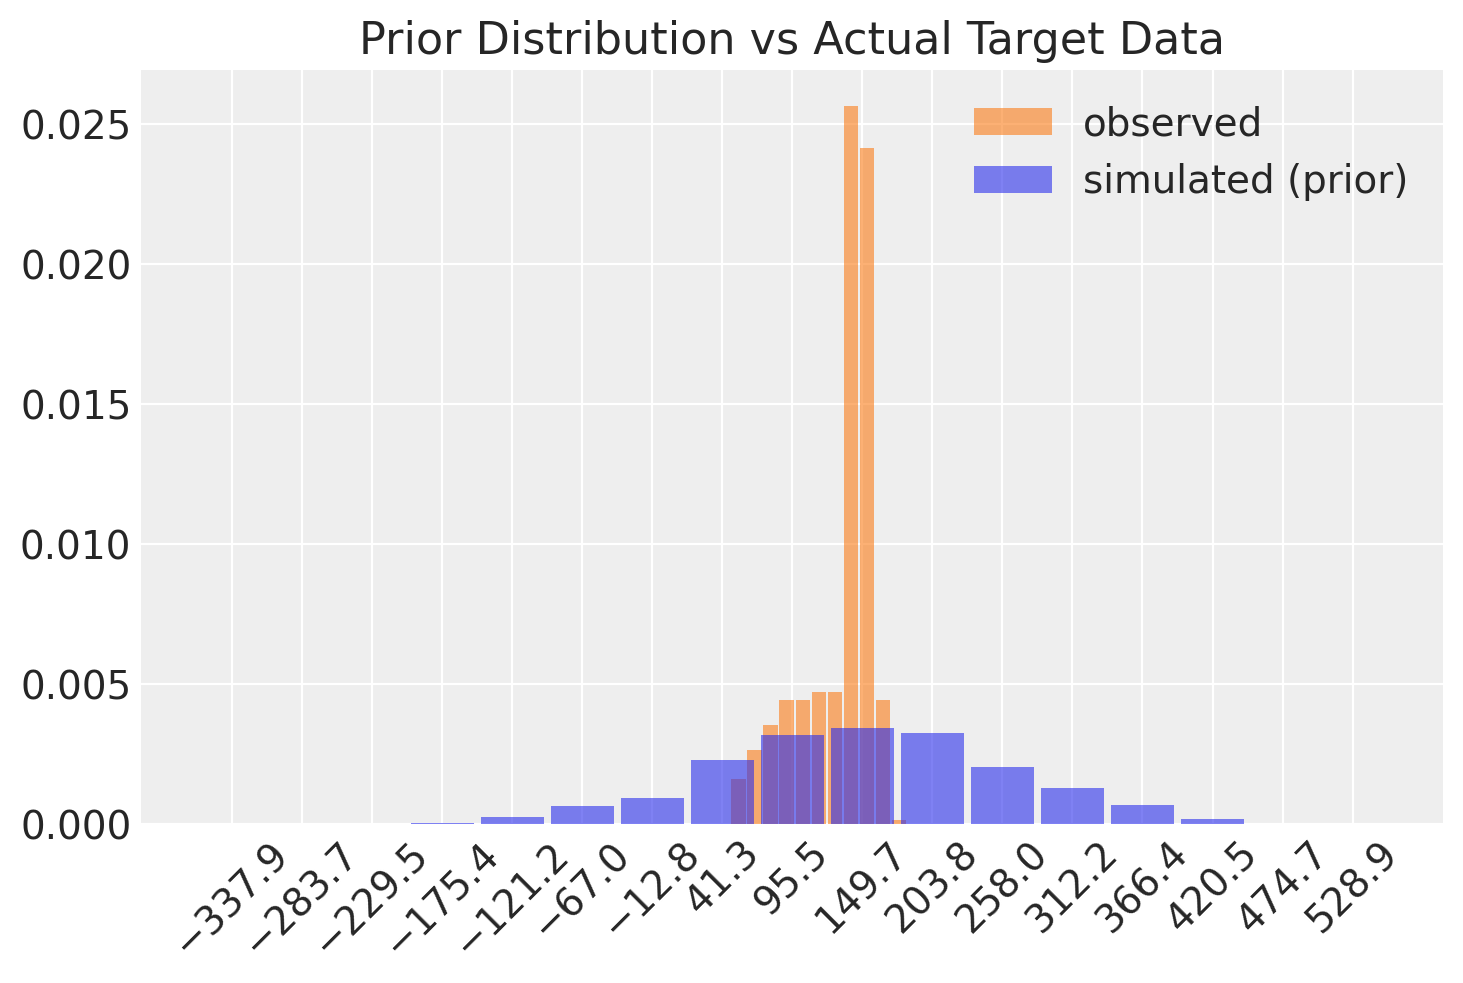

In [7]:
az.plot_dist(
    data['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_prior.prior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (prior)",
)
plt.xticks(rotation=45)
plt.title('Prior Distribution vs Actual Target Data');

# Posterior

In [8]:
with model_poly:
    # Train model
    idata_posterior = pm.sample(draws=1000, tune=1000)
    # Get samples from the posterior (predictions i.e. associated with the observed data)
    idata_predictive = pm.sample_posterior_predictive(
        idata_posterior,
        random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [height]


## Model Parameters

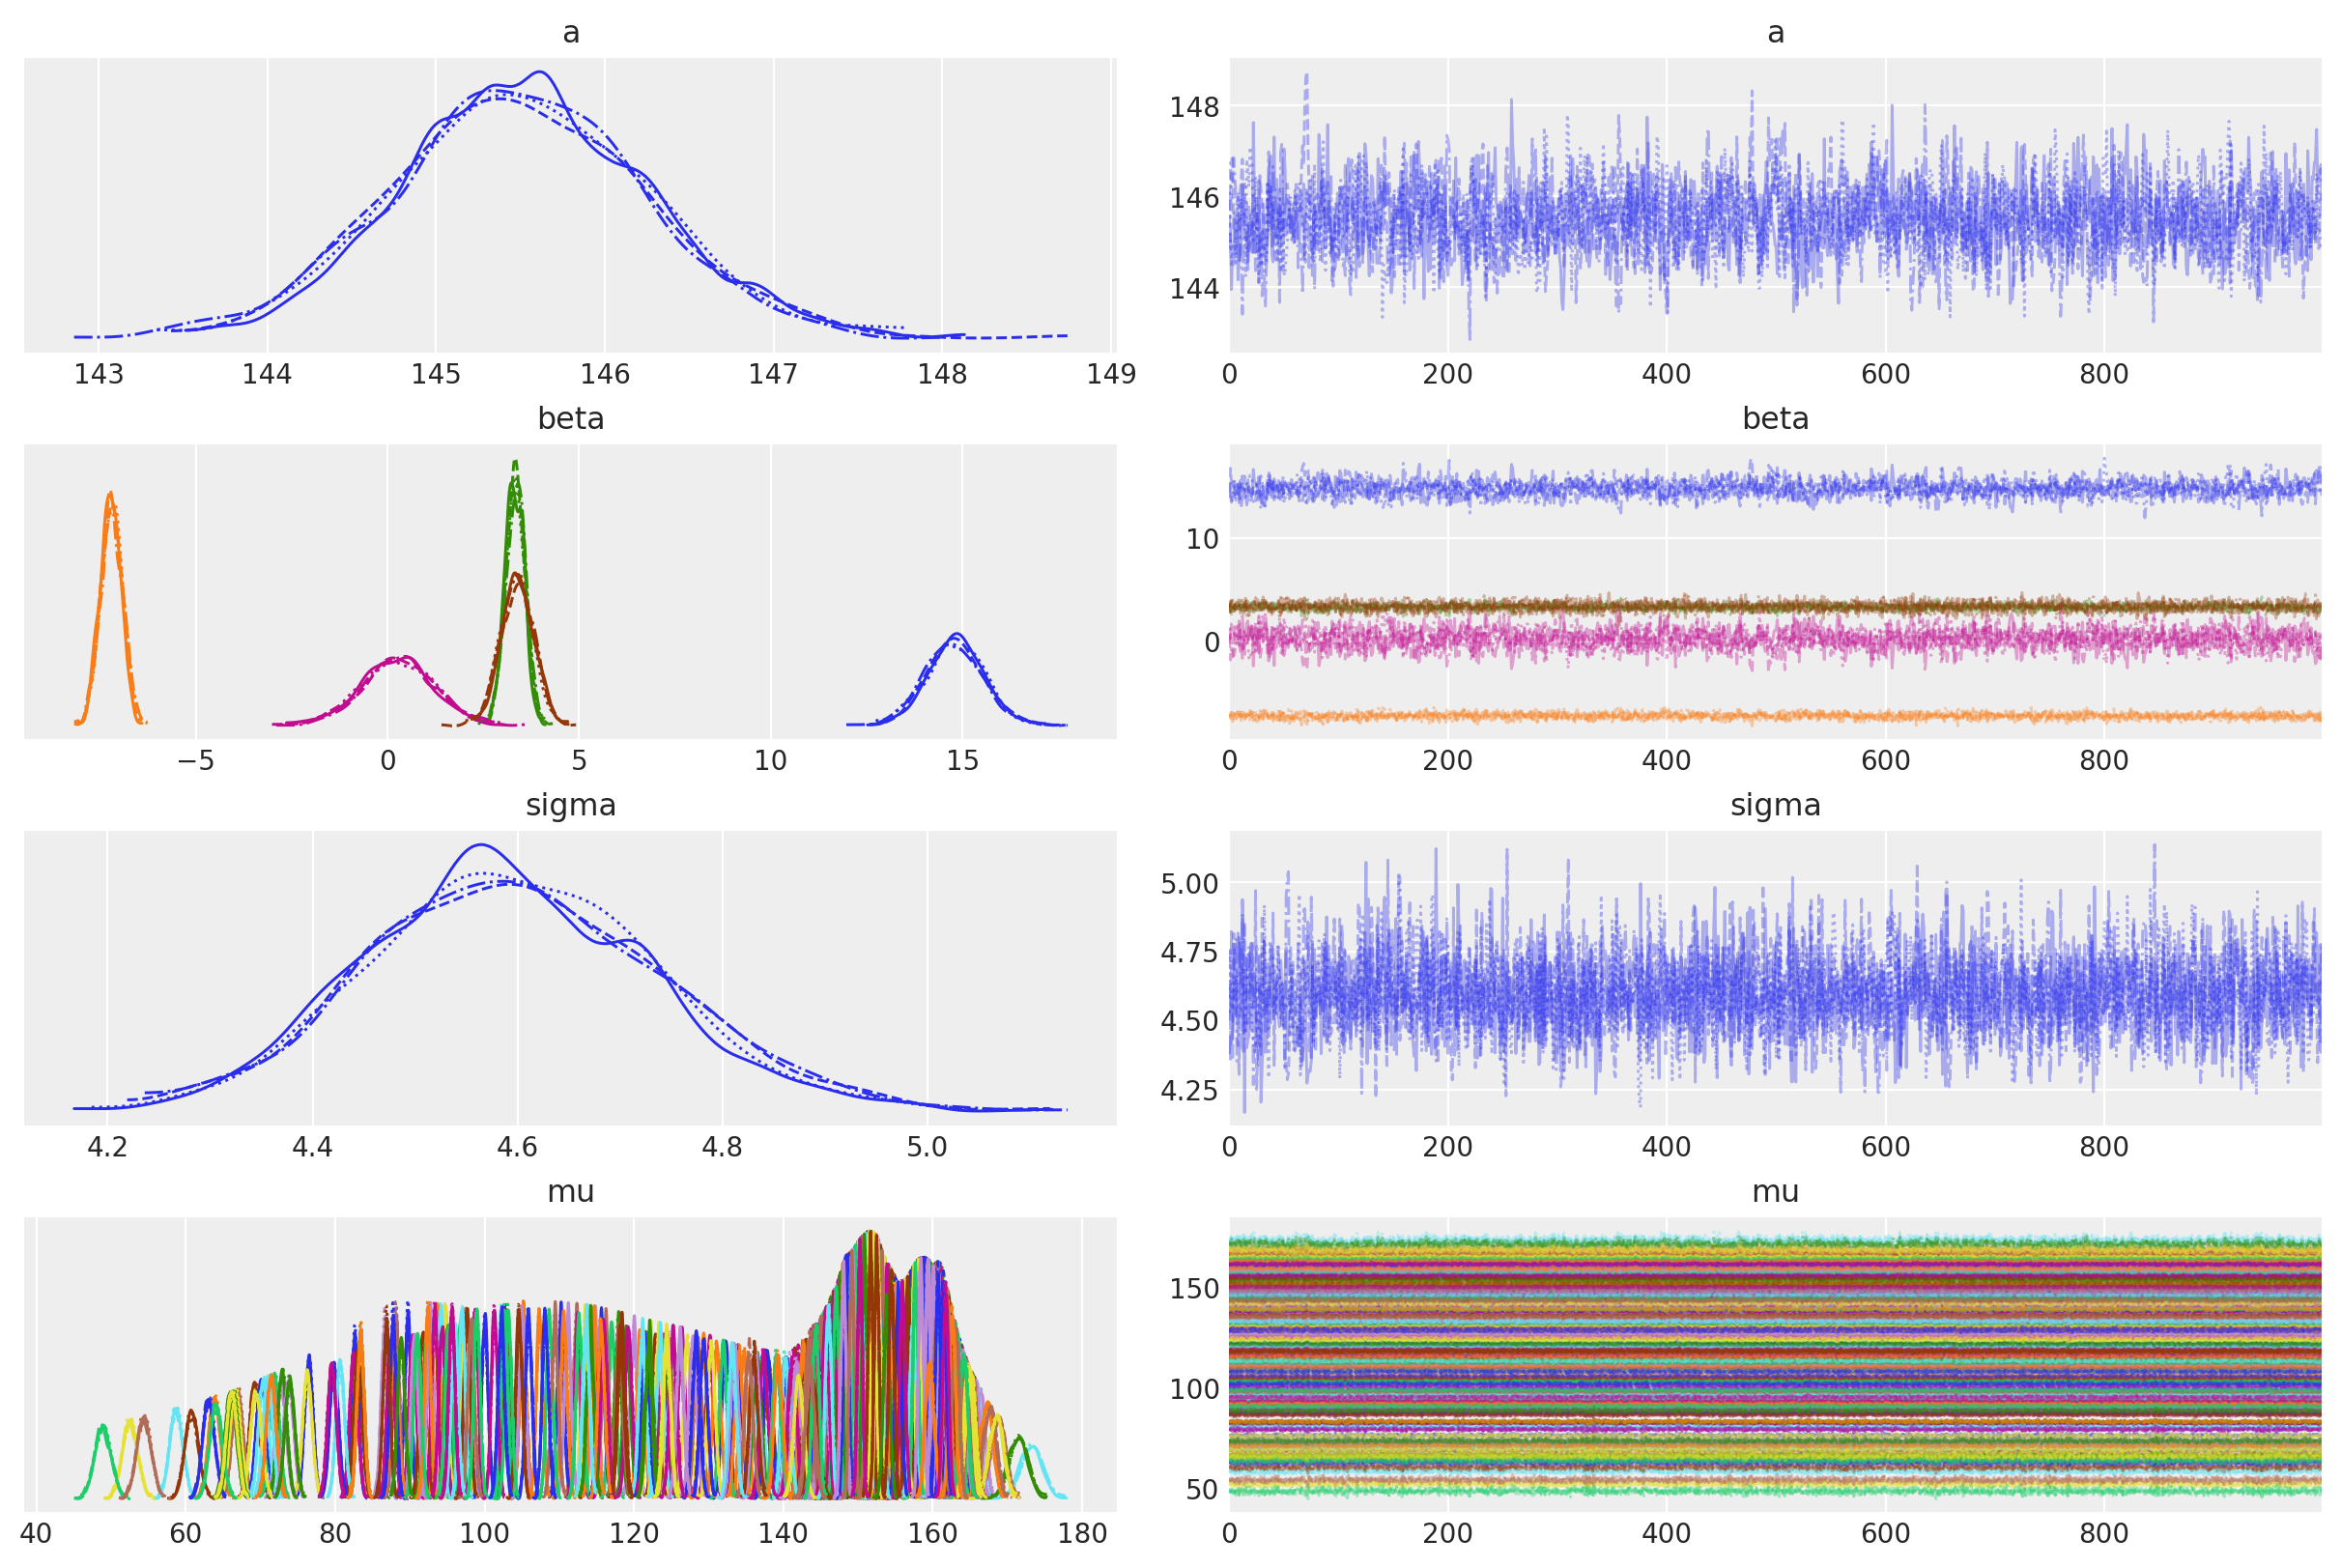

In [9]:
az.plot_trace(idata_posterior);

In [10]:
az.summary(idata_posterior, kind="stats")

mean     sd   hdi_3%  hdi_97%
a        145.504  0.753  144.109  146.914
beta[0]   14.801  0.756   13.277   16.139
beta[1]   -7.199  0.279   -7.716   -6.675
beta[2]    3.332  0.257    2.850    3.818
beta[3]    0.261  0.955   -1.490    2.138
...          ...    ...      ...      ...
mu[539]  143.610  0.606  142.490  144.766
mu[540]  161.436  0.377  160.700  162.113
mu[541]  159.584  0.570  158.555  160.638
mu[542]   73.936  0.662   72.678   75.154
mu[543]  161.721  0.387  161.036  162.477

[551 rows x 4 columns]

### Comparison w/ `statsmodels` linear regression

In [11]:
import statsmodels.api as sm

ols_x = data.drop(columns='height')
ols_y = data['height']

ols_x = pipeline.transform(ols_x)

ols_x = sm.add_constant(ols_x)
ols_model = sm.OLS(ols_y, ols_x).fit() 
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     3829.
Date:                Sun, 15 Jan 2023   Prob (F-statistic):               0.00
Time:                        23:11:02   Log-Likelihood:                -1597.2
No. Observations:                 544   AIC:                             3206.
Df Residuals:                     538   BIC:                             3232.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        145.5658      0.779    186.842      0.0

In [12]:
import plotly_express as px

ols_predictions = ols_model.predict(ols_x)
temp = data.copy()
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp["Predicted Heights (OLS)"] = ols_predictions

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Predicted Heights (OLS)",
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title="Actual vs Prediction (OLS)<br><sup>red line is perfect fit; blue line is actual fit</sup>",
)

perfect_line = px.line(
    pd.DataFrame(dict(x=np.arange(50, 180), y=np.arange(50, 180))),
    x='x',
    y='y',
)
perfect_line.update_traces(line_color='red', line_width=2)
fig.add_trace(perfect_line.data[0])
fig


---

## Target Variable

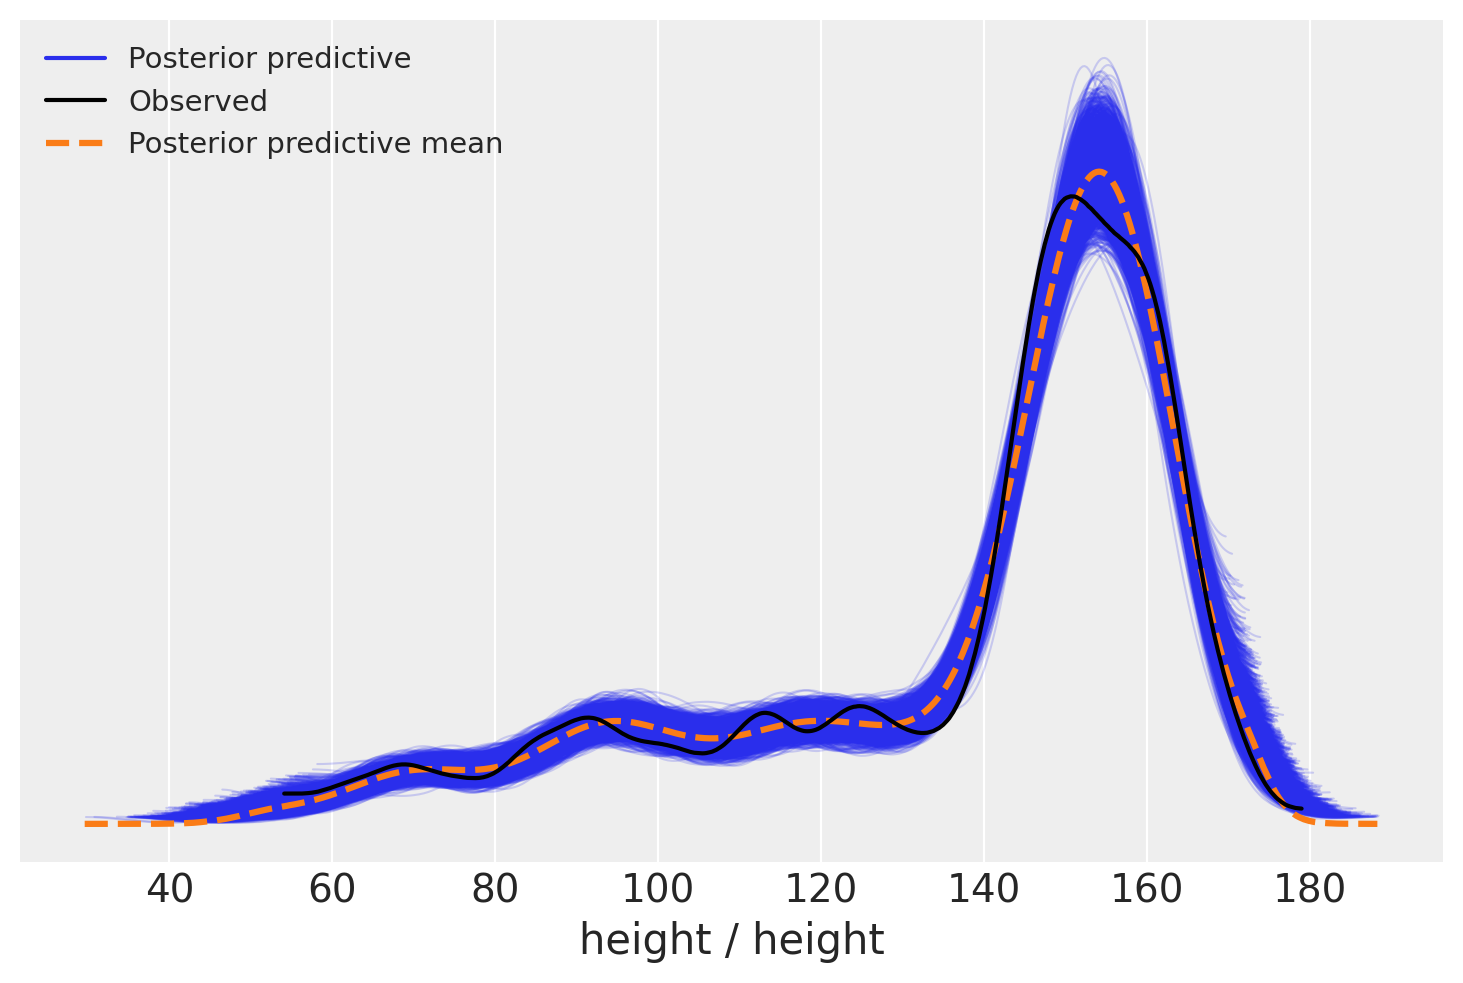

In [13]:
az.plot_ppc(idata_predictive);

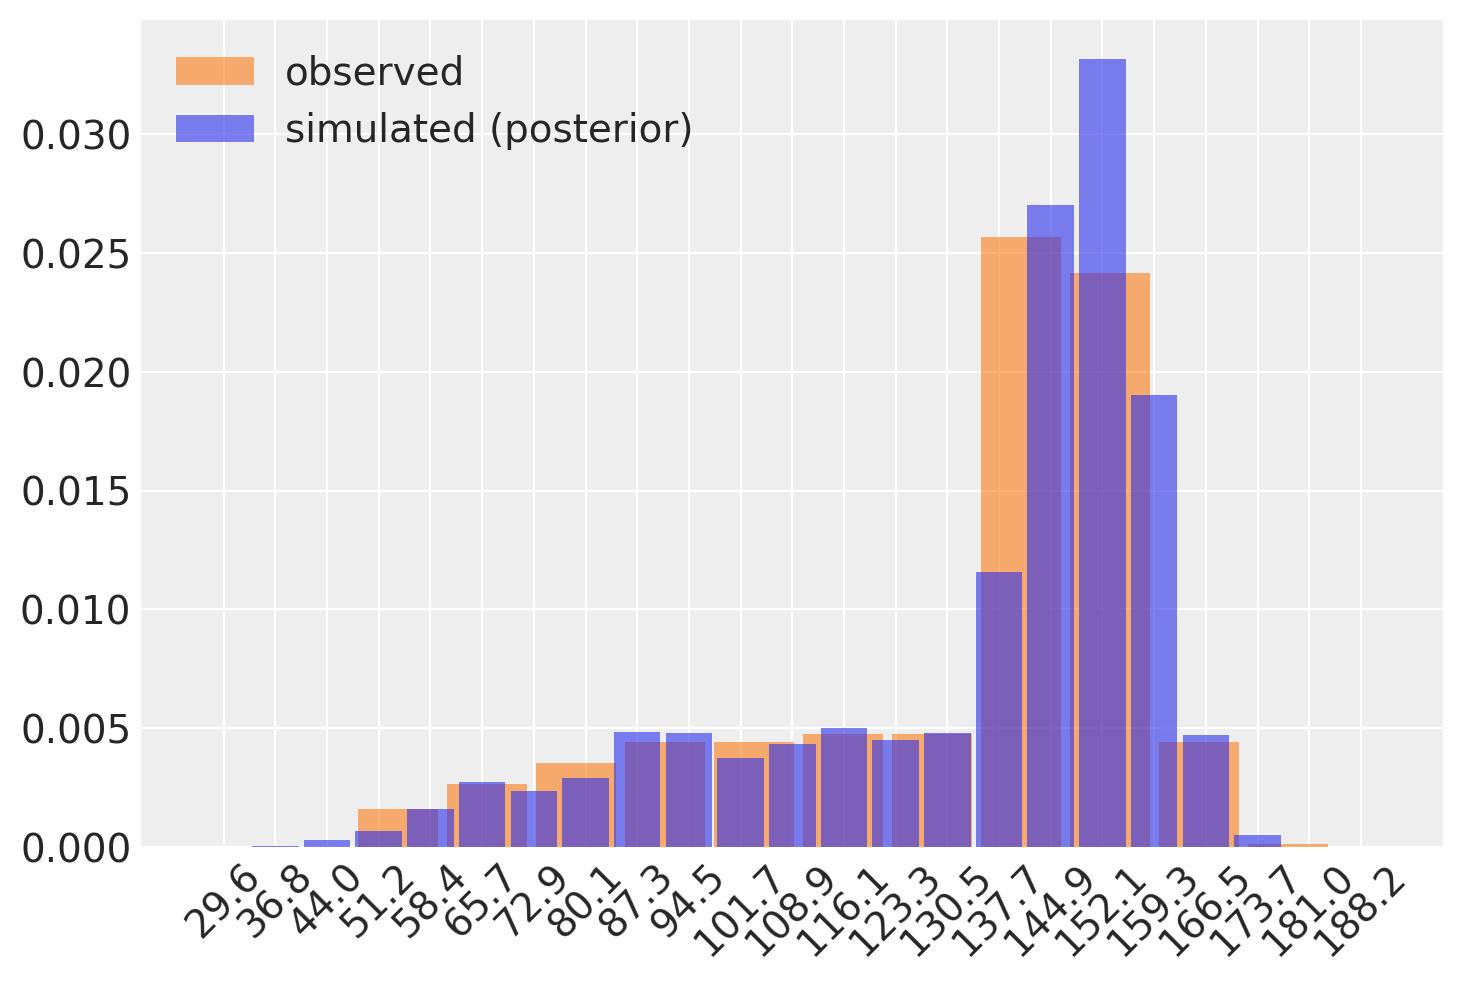

In [14]:

az.plot_dist(
    data['height'],
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    idata_predictive.posterior_predictive["height"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated (posterior)",
)
plt.xticks(rotation=45);

In [15]:
prediction_simulations = ph.get_posterior_samples(idata_predictive)
prediction_simulations.shape

(544, 4000)

In [16]:
print(prediction_simulations.min().min())
print(prediction_simulations.max().max())

29.622024922172606
188.54263029406843


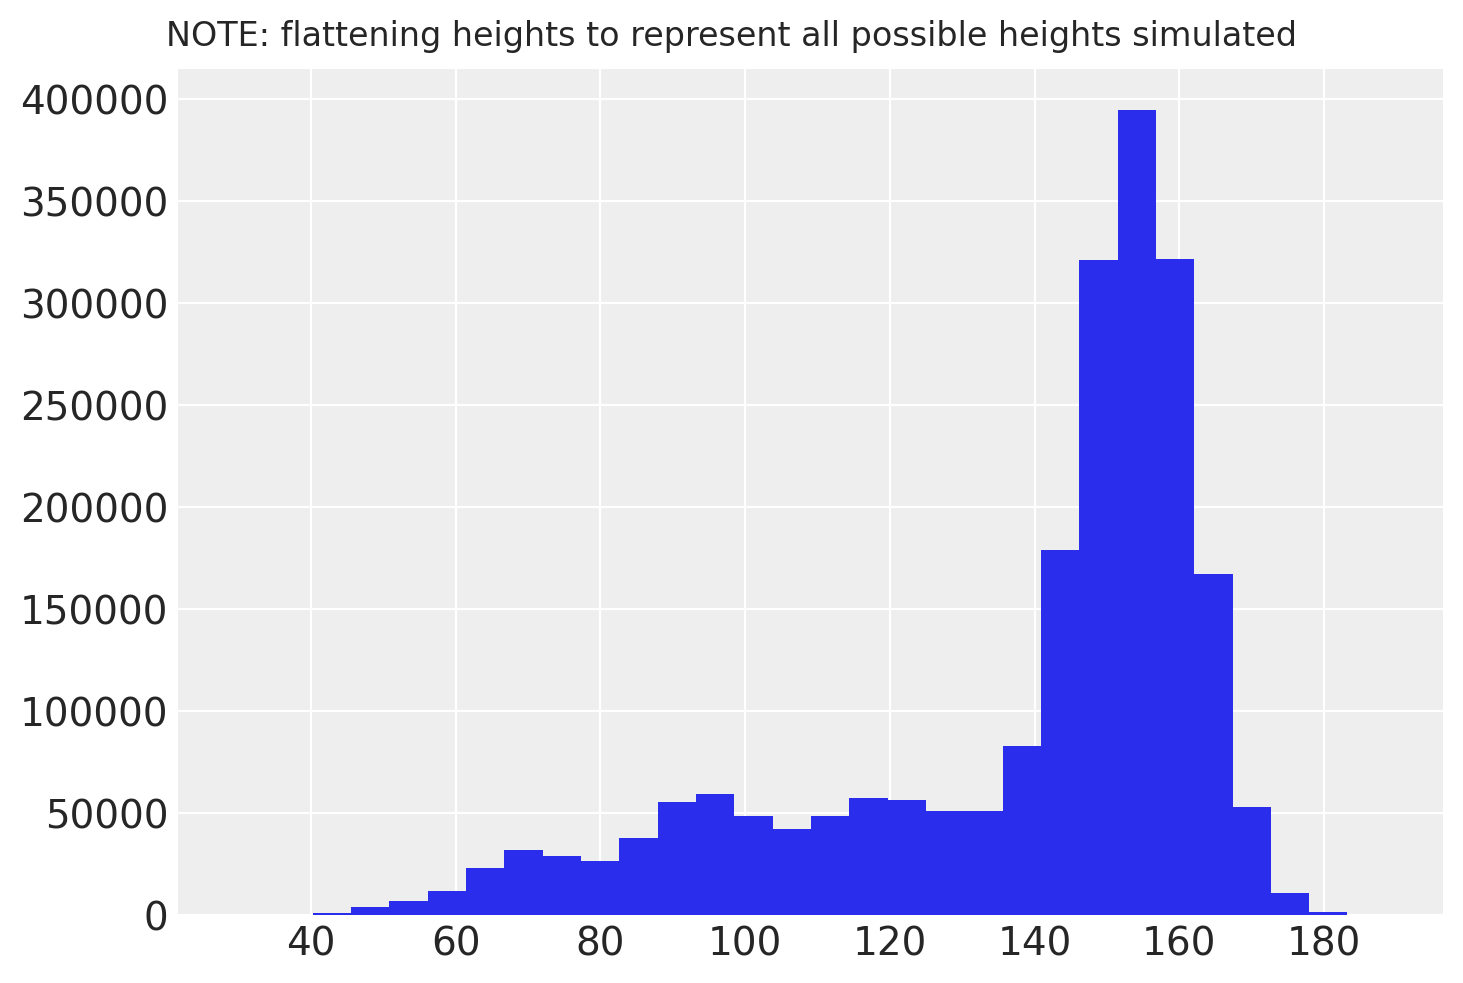

In [17]:
plt.hist(prediction_simulations.flatten(), bins=30)
plt.suptitle('NOTE: flattening heights to represent all possible heights simulated');

Each height is associated with `4000` simulated values. Now get the median/expected value and plot histogram of median values just to see the difference.

In [18]:
print(np.median(prediction_simulations, axis=1).min())
print(np.median(prediction_simulations, axis=1).max())

48.847576923438695
173.17918215156703


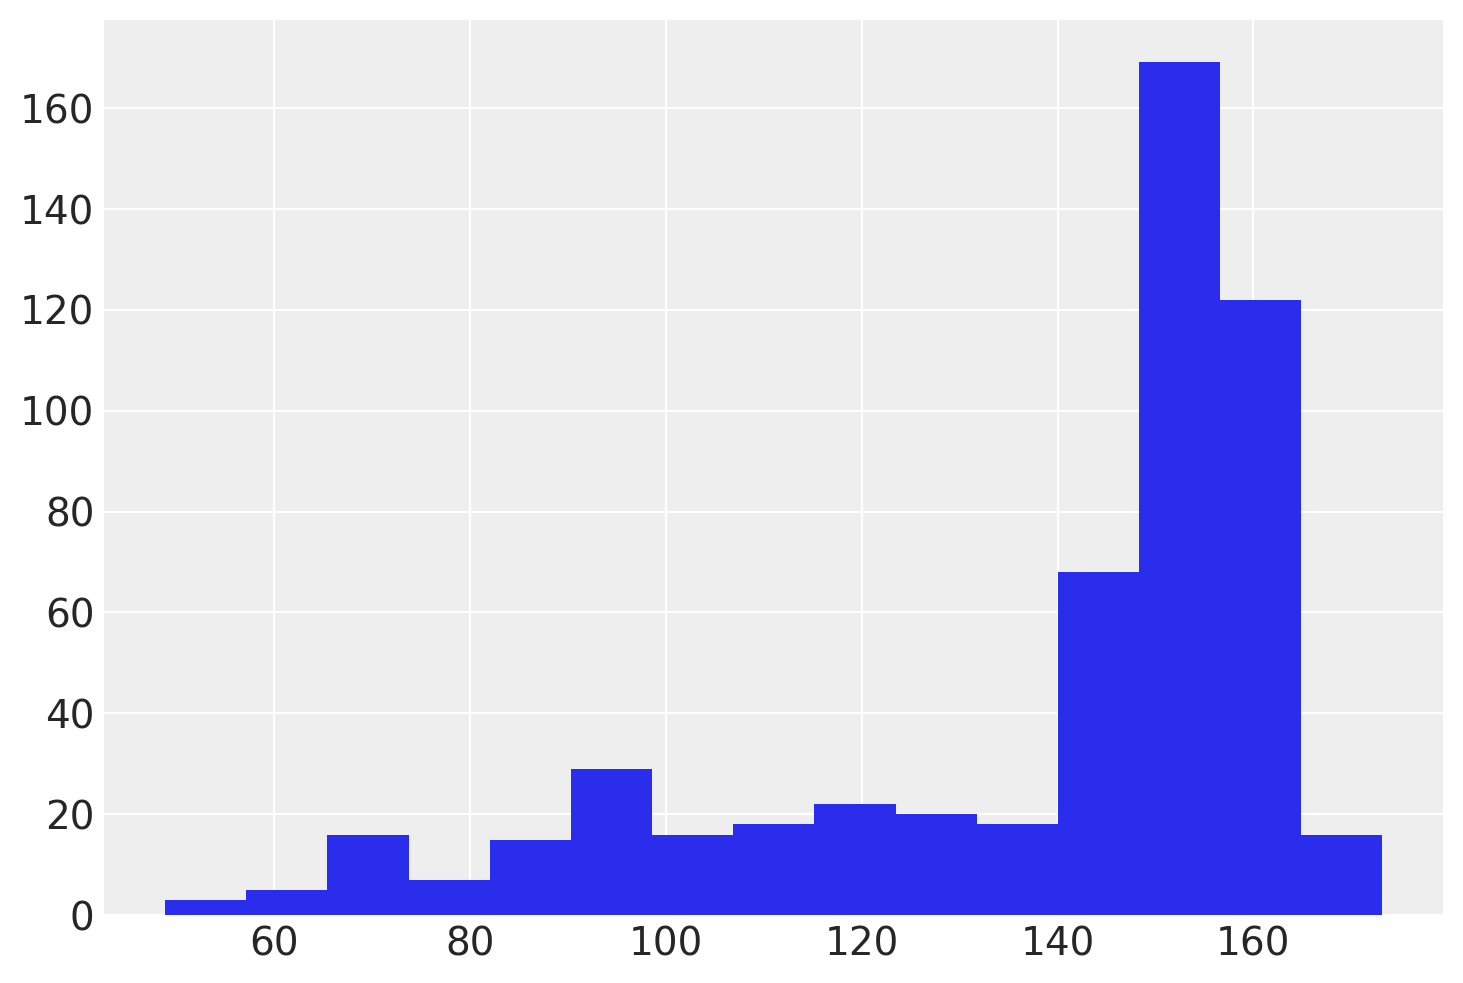

In [19]:
plt.hist(np.median(prediction_simulations, axis=1), bins=15);

In [20]:
az.summary(idata_posterior, kind="stats")

mean     sd   hdi_3%  hdi_97%
a        145.504  0.753  144.109  146.914
beta[0]   14.801  0.756   13.277   16.139
beta[1]   -7.199  0.279   -7.716   -6.675
beta[2]    3.332  0.257    2.850    3.818
beta[3]    0.261  0.955   -1.490    2.138
...          ...    ...      ...      ...
mu[539]  143.610  0.606  142.490  144.766
mu[540]  161.436  0.377  160.700  162.113
mu[541]  159.584  0.570  158.555  160.638
mu[542]   73.936  0.662   72.678   75.154
mu[543]  161.721  0.387  161.036  162.477

[551 rows x 4 columns]

In [21]:
az.summary(idata_predictive, kind="stats")

/usr/local/lib/python3.10/site-packages/arviz/stats/stats.py:1351: UserWarning:

Selecting first found group: posterior_predictive



mean     sd   hdi_3%  hdi_97%
height[0]    158.462  4.592  150.569  167.839
height[1]    146.812  4.482  139.058  156.102
height[2]    141.326  4.512  133.181  149.861
height[3]    162.127  4.676  153.268  170.618
height[4]    150.550  4.624  142.360  159.480
...              ...    ...      ...      ...
height[539]  143.679  4.708  134.983  152.390
height[540]  161.390  4.573  152.201  169.531
height[541]  159.646  4.628  151.039  168.268
height[542]   73.962  4.580   65.539   82.562
height[543]  161.564  4.657  152.740  170.204

[544 rows x 4 columns]

In [22]:
posterior_target_samples = ph.get_posterior_samples(idata_predictive)
posterior_target_point_predictions = np.median(posterior_target_samples, axis=1)
assert posterior_target_samples.shape[0] == len(posterior_target_point_predictions)

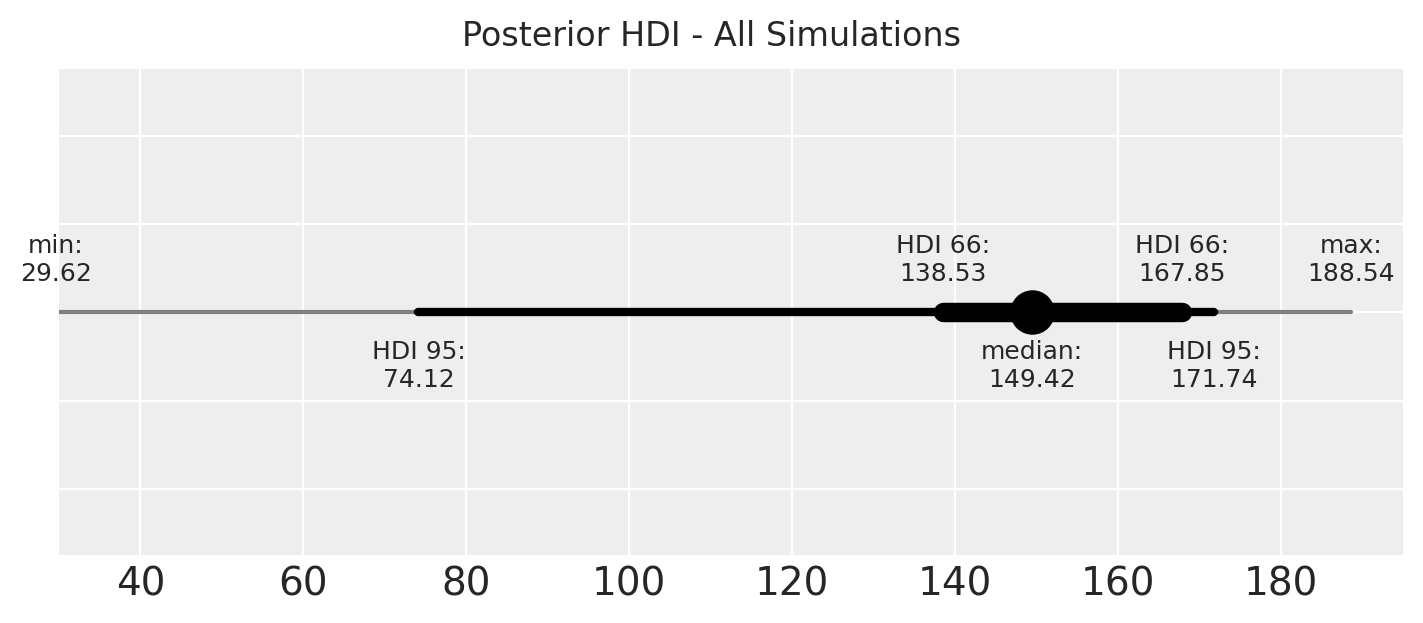

In [23]:
from helpsk.string import format_number

samples_flattened = posterior_target_samples.flatten()

sim_min, sim_median, sim_max = np.quantile(samples_flattened, q=[0, 0.5, 1])
sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(samples_flattened, hdi_prob=0.95)
sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(samples_flattened, hdi_prob=0.66)

def plot_text(x, label, above=True):
    y = 0.012
    if not above:
        y *= -1
    return plt.text(x=x, y=y, s=f"{label}:\n{format_number(x)}", ha='center', va='center', fontsize=9)

fig, ax = plt.subplots(1)
plt.plot([sim_min, sim_max], [0, 0], color='gray')
plt.plot([sim_95_hdi_prob_low, sim_95_hdi_prob_hi], [0, 0], color='black', linewidth=3)
plt.plot([sim_66_hdi_prob_low, sim_66_hdi_prob_hi], [0, 0], color='black', linewidth=7)
plt.plot(sim_median, 0, 'o', markersize=15, color='black')
ax.set_yticklabels([])
plot_text(x=sim_min, label='min')
plot_text(x=sim_max, label="max")
plot_text(x=sim_median, label="median", above=False)
plot_text(x=sim_66_hdi_prob_low, label="HDI 66")
plot_text(x=sim_66_hdi_prob_hi, label="HDI 66")
plot_text(x=sim_95_hdi_prob_low, label="HDI 95", above=False)
plot_text(x=sim_95_hdi_prob_hi, label="HDI 95", above=False)
fig.set_size_inches(w=7, h=3)
plt.xlim((30, 195))
plt.suptitle("Posterior HDI - All Simulations");

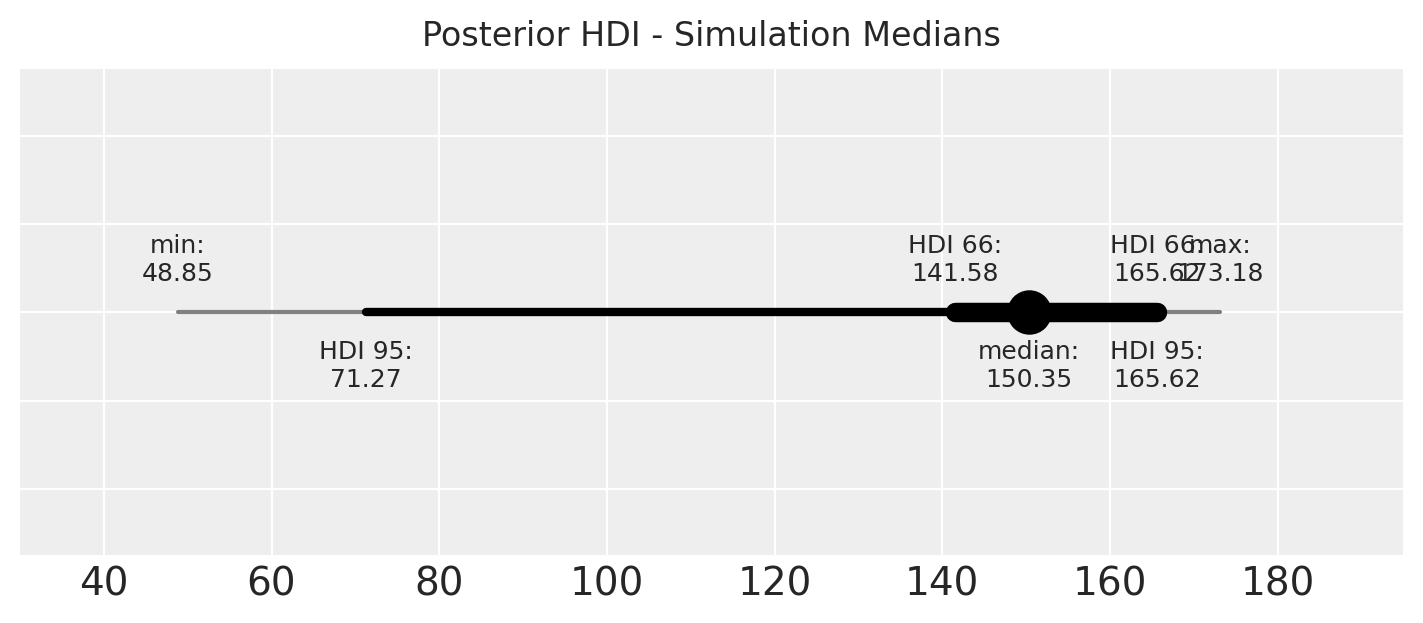

In [24]:
from helpsk.string import format_number

sim_min, sim_median, sim_max = np.quantile(posterior_target_point_predictions, q=[0, 0.5, 1])
sim_95_hdi_prob_low, sim_95_hdi_prob_hi = az.hdi(posterior_target_point_predictions, hdi_prob=0.95)
sim_66_hdi_prob_low, sim_66_hdi_prob_hi = az.hdi(posterior_target_point_predictions, hdi_prob=0.66)

def plot_text(x, label, above=True):
    y = 0.012
    if not above:
        y *= -1
    return plt.text(x=x, y=y, s=f"{label}:\n{format_number(x)}", ha='center', va='center', fontsize=9)

fig, ax = plt.subplots(1)
plt.plot([sim_min, sim_max], [0, 0], color='gray')
plt.plot([sim_95_hdi_prob_low, sim_95_hdi_prob_hi], [0, 0], color='black', linewidth=3)
plt.plot([sim_66_hdi_prob_low, sim_66_hdi_prob_hi], [0, 0], color='black', linewidth=7)
plt.plot(sim_median, 0, 'o', markersize=15, color='black')
ax.set_yticklabels([])
plot_text(x=sim_min, label='min')
plot_text(x=sim_max, label="max")
plot_text(x=sim_median, label="median", above=False)
plot_text(x=sim_66_hdi_prob_low, label="HDI 66")
plot_text(x=sim_66_hdi_prob_hi, label="HDI 66")
plot_text(x=sim_95_hdi_prob_low, label="HDI 95", above=False)
plot_text(x=sim_95_hdi_prob_hi, label="HDI 95", above=False)
plt.xlim((30, 195))
fig.set_size_inches(w=7, h=3)
plt.suptitle("Posterior HDI - Simulation Medians");

## Actual vs Predicted

In [28]:
import plotly_express as px

temp = data.copy()
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp["Predicted Heights"] = posterior_target_point_predictions

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Predicted Heights",
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title="Actual vs Prediction<br><sup>red line is perfect fit; blue line is actual fit</sup>",
)

perfect_line = px.line(
    pd.DataFrame(dict(x=np.arange(50, 180), y=np.arange(50, 180))),
    x='x',
    y='y',
)
perfect_line.update_traces(line_color='red', line_width=2)
fig.add_trace(perfect_line.data[0])
fig


## Residuals

In [26]:
import plotly_express as px

temp = data.copy()
temp.rename(columns={'height': "Actual Heights"}, inplace=True)
temp["Residuals"] = posterior_target_point_predictions - temp['Actual Heights']

fig = px.scatter(
    temp,
    x="Actual Heights",
    y="Residuals",
    trendline='lowess',
    trendline_options=dict(frac=0.1),
    title="Actual vs Residual (Predicted - Actual)<br><sup>red line is perfect fit; blue line is actual fit</sup>",
)
fig.add_hline(y=0, line_width=3, line_color="red")
fig


---

# New Predictions

In [35]:
new_data = pd.DataFrame(dict(
    weight=[10, 20, 30, 40],
    age=[10, 20, 30, 40],
    male=[1, 0, 0, 0],
))
new_data = pipeline.transform(new_data)
print(new_data)
prediction_sims = ph.posterior_predict(
    model=model_poly,
    idata_posterior=idata_posterior,
    data=new_data
)
prediction_sims

Sampling: [height]


[[-1.74155031  3.03299747 -5.28211767  0.          1.        ]
 [-1.06153925  1.12686558 -1.19621205  1.          0.        ]
 [-0.3815282   0.14556377 -0.05553668  1.          0.        ]
 [ 0.29848286  0.08909202  0.02659244  1.          0.        ]]


array([[ 83.68042272,  80.43004727,  82.64700922, ...,  83.53054132,
         82.71111216,  82.53771783],
       [119.01302301, 114.75645741, 112.36457625, ..., 118.49911586,
        117.16726448, 115.66761026],
       [138.8466397 , 132.72107924, 136.45487718, ..., 148.19589028,
        128.32989253, 140.19893132],
       [155.89476726, 148.82161209, 151.98146002, ..., 150.77261   ,
        152.91862963, 148.64124364]])

In [36]:
np.median(prediction_sims, axis=1)

array([ 83.87501703, 117.79148168, 138.72495245, 149.72538021])

---